# openibis — Depth of Anaesthesia Scoring
This notebook loads EEG case files, automatically detects and resamples to 128 Hz, runs the openibis algorithm, and validates scores against reference BIS values.


## Cell 1 — Install dependencies
Run once if you haven't already installed these packages.

In [1]:
%pip install numpy scipy matplotlib h5py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Cell 2 — Import

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
from scipy import stats
from scipy.signal import butter, lfilter, resample_poly

try:
    import scipy.io as sio
    import h5py
except ImportError:
    raise ImportError('Run Cell 1 first to install dependencies.')
%matplotlib inline
print('Imports OK')
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='All-NaN slice')

Imports OK


## Cell 3 — Configuration
**Set the path to the folder containing your `.mat` case files here.**

In [3]:
CASE_FOLDER = pathlib.Path('../data/')  # <-- CHANGE THIS as needed

mat_files = sorted(CASE_FOLDER.glob('*.mat'))
print(f'Found {len(mat_files)} .mat file(s):')
for f in mat_files:
    print(f'  {f.name}')

Found 24 .mat file(s):
  case1.mat
  case10.mat
  case11.mat
  case12.mat
  case13.mat
  case14.mat
  case15.mat
  case16.mat
  case17.mat
  case18.mat
  case19.mat
  case2.mat
  case20.mat
  case21.mat
  case22.mat
  case23.mat
  case24.mat
  case3.mat
  case4.mat
  case5.mat
  case6.mat
  case7.mat
  case8.mat
  case9.mat


## Cell 4 — Core algorithm (openibis)

In [4]:
# ── Signal utilities ──────────────────────────────────────────────────────────

def _baseline(x):
    n  = len(x)
    v  = np.column_stack([np.ones(n), np.arange(1, n+1)])
    coeffs, _, _, _ = np.linalg.lstsq(v, x, rcond=None)
    return v @ coeffs

def _bound(x, lo, hi):   return np.clip(x, lo, hi)

def _band_range(f_start, f_end, bin_size):
    start = int(round(f_start / bin_size))
    end   = int(round(f_end   / bin_size))
    return np.arange(start, end + 1)

def _time_range(seconds, n, stride):
    start = max(1, n - int(seconds / stride) + 1)
    return np.arange(start, n + 1)

def _piecewise(x, xp, yp):
    return np.interp(_bound(np.asarray(x, dtype=float), float(xp[0]), float(xp[-1])), xp, yp)

def _scurve(x, Eo, Emax, x50, xwidth):
    return Eo - Emax / (1.0 + np.exp((np.asarray(x, dtype=float) - x50) / xwidth))

def _prctmean(x, p_low, p_high):
    x = x[np.isfinite(x)]
    if len(x) == 0: return np.nan
    lo, hi = np.percentile(x, p_low), np.percentile(x, p_high)
    vals = x[(x >= lo) & (x <= hi)]
    return float(np.mean(vals)) if len(vals) else np.nan

def _mean_band_power(psd, f_start, f_end, bin_size):
    idx  = _band_range(f_start, f_end, bin_size)
    vals = psd[:, idx].flatten()
    vals = vals[np.isfinite(vals) & (vals > 0)]
    return float(np.mean(10 * np.log10(vals))) if len(vals) else np.nan

# ── Epoch helpers ─────────────────────────────────────────────────────────────

def _n_epochs(eeg, Fs, stride):
    n_stride = int(Fs * stride)
    N        = int(np.floor((len(eeg) - Fs) / n_stride)) - 10
    return N, n_stride

def _segment(eeg, from_stride, number, n_stride):
    start = int(from_stride * n_stride)
    return eeg[start : start + number * n_stride]

def _is_not_burst_suppressed(bsr_map, n, p):
    if n < p:
        return False
    return not np.any(bsr_map[n-p : n])

# ── Burst suppression ─────────────────────────────────────────────────────────

def suppression(eeg, Fs, stride):
    N, n_stride = _n_epochs(eeg, Fs, stride)
    bsr_map     = np.zeros(N, dtype=bool)
    
    for n in range(1, N + 1):
        x        = _segment(eeg, n + 6.5, 2, n_stride)
        # Exclude flatline/dropout segments (std < 0.5 uV is not real EEG)
        if np.std(x) < 0.5:
            bsr_map[n-1] = False
            continue
        bl           = _baseline(x)
        bsr_map[n-1] = bool(np.all(np.abs(x - bl) <= 5))
    
    window = int(63 / stride)
    bsr    = np.array([100.0 * np.mean(bsr_map[max(0, n - window + 1) : n+1])
                       for n in range(N)])
    return bsr_map, bsr

# ── PSD helpers ───────────────────────────────────────────────────────────────

def _power_spectral_density(x):
    x   = x - _baseline(x)
    win = np.blackman(len(x))
    f   = np.fft.fft(win * x)
    h   = len(x) // 2
    return 2 * np.abs(f[:h])**2 / (len(x) * np.sum(win**2))

def _sawtooth_detector(eeg, n_stride):
    saw       = np.zeros(n_stride)
    saw[-5:]  = np.arange(1, 6, dtype=float)
    saw       = (saw - saw.mean()) / saw.std(ddof=0)
    L         = len(eeg) - len(saw)
    if L <= 0: return False
    v     = np.array([np.var(eeg[i:i+len(saw)], ddof=0) for i in range(L)])
    m_fwd = (np.convolve(eeg, saw[::-1], 'valid')[:L] / len(saw))**2
    m_rev = (np.convolve(eeg, saw,       'valid')[:L] / len(saw))**2
    with np.errstate(invalid='ignore', divide='ignore'):
        r_fwd = np.where(v > 10, m_fwd / v, 0.0)
        r_rev = np.where(v > 10, m_rev / v, 0.0)
    return bool(np.max(np.maximum(r_fwd, r_rev)) > 0.63)

# ── Log power ratios ──────────────────────────────────────────────────────────

def log_power_ratios(eeg, Fs, stride, bsr_map):
    N, n_stride = _n_epochs(eeg, Fs, stride)
    B, A        = butter(2, 0.65 / (Fs / 2), btype='high')
    eeg_hp      = lfilter(B, A, eeg)
    n_bins      = 4 * n_stride // 2
    psd         = np.full((N, n_bins), np.nan)
    sup_filter  = _piecewise(np.arange(0, 64, 0.5), [0, 3, 6], [0, 0.25, 1])**2
    components  = np.full((N, 3), np.nan)

    for n in range(1, N + 1):
        idx = n - 1
        if _is_not_burst_suppressed(bsr_map, n, 4):
            seg = _segment(eeg_hp, n + 4, 4, n_stride)
            if np.std(seg) >= 0.5:   # skip dropout/flatline segments
                psd[idx, :] = _power_spectral_density(seg)
                if _sawtooth_detector(_segment(eeg, n + 4, 4, n_stride), n_stride):
                    psd[idx, :] *= sup_filter

        t30    = _time_range(30, n, stride)           # 1-based indices
        t30_0  = t30 - 1                               # 0-based
        t30_0  = t30_0[t30_0 < N]
        if len(t30_0) == 0: continue
        p30    = psd[t30_0, :]

        vha = _band_range(39.5, 46.5, 0.5);  vhb = _band_range(40.0, 47.0, 0.5)
        wha = _band_range( 0.5, 46.5, 0.5);  whb = _band_range( 1.0, 47.0, 0.5)

        with np.errstate(invalid='ignore'):
            vhigh = np.sqrt(np.nanmean(p30[:, vha] * p30[:, vhb], axis=1))
            whole = np.sqrt(np.nanmean(p30[:, wha] * p30[:, whb], axis=1))

        mid_bp = _prctmean(np.nanmean(10*np.log10(np.maximum(p30[:, _band_range(11,20,0.5)], 1e-30)), axis=1), 50, 100)

        components[idx, 0] = _mean_band_power(p30, 30, 47, 0.5) - mid_bp

        with np.errstate(invalid='ignore', divide='ignore'):
            ratio = vhigh / whole
        valid = np.isfinite(ratio) & (ratio > 0)
        #components[idx, 1] = float(np.mean(10*np.log10(ratio[valid]))) if valid.any() else np.nan
        if valid.any():
            vals = 10 * np.log10(ratio[valid])
            lo   = np.percentile(vals, 25)
            hi   = np.percentile(vals, 75)
            components[idx, 1] = float(np.mean(vals[(vals >= lo) & (vals <= hi)]))
        else:
            components[idx, 1] = np.nan

        components[idx, 2] = _mean_band_power(p30, 0.5, 4, 0.5) - mid_bp

    return components

# ── Mixer (corrected from paper) ──────────────────────────────────────────────

def mixer(components, bsr):
    c1, c2, c3  = components[:, 0], components[:, 1], components[:, 2]

    # Sedation S-curve — recalibrated parameters
    sed_score   = _scurve(c1, 107.661, 63.407, -6.379, 5.485)

    # General score — recalibrated x50 and xwidth
    gen_score   = _piecewise(c2, [-60.89, -30], [-40, 43.1])
    gen_score  += _scurve(c2, 61.3, 72.6, -14.102, 2.887) * (c2 >= -30).astype(float)

    bsr_score   = _piecewise(bsr, [0, 100], [50, 0])

    # c3_hi fitted to 0.0 — general score always dominates when gen < sed
    gen_weight  = _piecewise(c3, [0, 0.001], [0.5, 1]) * (gen_score < sed_score).astype(float)
    bsr_weight  = _piecewise(bsr, [10, 50], [0, 1])

    x = sed_score * (1 - gen_weight) + gen_score * gen_weight
    y = _piecewise(x, [-40, 10, 97, 110], [0, 10, 97, 100]) * (1 - bsr_weight) + bsr_score * bsr_weight

    return y

# ── Main entry point ──────────────────────────────────────────────────────────

def openibis(eeg):
    Fs, stride   = 128, 0.5
    bsr_map, bsr = suppression(eeg, Fs, stride)
    components   = log_power_ratios(eeg, Fs, stride, bsr_map)
    return mixer(components, bsr)

print('openibis algorithm reloaded with fixes from paper ✓')

openibis algorithm reloaded with fixes from paper ✓


## Cell 5 — Sampling rate detection & resampling

In [5]:
CANDIDATE_RATES = [256, 512, 128, 1000, 500, 250, 2048, 1024, 200, 2000]
TARGET_FS       = 128

def _spectral_score(eeg, fs_candidate):
    freqs   = np.fft.rfftfreq(len(eeg), d=1.0 / fs_candidate)
    psd     = np.abs(np.fft.rfft(eeg - np.median(eeg)))**2
    cutoff  = min(80.0, fs_candidate / 2 * 0.95)
    total   = psd.sum()
    return float(psd[freqs <= cutoff].sum() / total) if total > 0 else 0.0

def detect_fs(eeg, candidates=CANDIDATE_RATES):
    snippet = eeg[:int(max(candidates) * 30)]
    scores  = {fs: _spectral_score(snippet, fs) for fs in candidates}
    return float(max(scores, key=scores.get))

def prepare_eeg(eeg, candidates=CANDIDATE_RATES):
    fs      = detect_fs(eeg, candidates)
    fs_int  = int(round(fs))
    if fs_int == TARGET_FS:
        return eeg.copy().astype(float), fs
    g   = gcd(TARGET_FS, fs_int)
    out = resample_poly(eeg, TARGET_FS // g, fs_int // g).astype(float)
    return out, fs

print('Resampling utilities loaded OK')


Resampling utilities loaded OK


## Cell 6 — File loading

In [6]:
def load_mat(mat_path):
    try:
        mat = sio.loadmat(mat_path)
        return {k: np.array(v).squeeze() for k, v in mat.items()
                if not k.startswith('_')}
    except NotImplementedError:
        out = {}
        with h5py.File(mat_path, 'r') as f:
            for k in f.keys():
                out[k] = np.array(f[k]).squeeze()
        return out

print('File loader ready')

def align(scores, bis):
    n_bis     = len(bis)
    n_scores  = len(scores)
    ratio     = n_scores / n_bis          # e.g. ~9.8 epochs per BIS sample
    
    aligned_scores = np.array([
        np.nanmean(scores[int(i * ratio) : int((i + 1) * ratio)])
        for i in range(n_bis)
    ])
    
    s = aligned_scores.astype(float)
    b = bis.astype(float)
    valid = np.isfinite(s) & np.isfinite(b)
    return s[valid], b[valid]


File loader ready


In [7]:
# Inspect the first .mat file to see what variables are inside
with h5py.File(mat_files[0], 'r') as f:
    print(f"Keys in {mat_files[0].name}:")
    for k in f.keys():
        v = f[k]
        print(f"  '{k}'  shape={np.array(v).shape}  dtype={np.array(v).dtype}")

Keys in case1.mat:
  'EEG'  shape=(1, 481384)  dtype=float64
  'bis'  shape=(1, 767)  dtype=float64


## Cell 7 — Run openibis on all cases

In [8]:
results = []   # list of dicts, one per case

for mat_path in mat_files:
    try:
        data          = load_mat(mat_path)
        eeg_raw       = data['EEG'].astype(float).flatten()
        bis           = data['bis'].astype(float).flatten()
        eeg, det_fs   = prepare_eeg(eeg_raw)
        scores        = openibis(eeg)

        # Align lengths and drop NaNs
        s, b = align(scores, bis)

        results.append(dict(name=mat_path.stem, scores=s, bis=b, det_fs=det_fs))
        fs_note = f'{det_fs:.0f}→128 Hz' if det_fs != 128 else '128 Hz'
        print(f'  ✓  {mat_path.name:<35}  {len(s):>5} epochs  [{fs_note}]')

    except Exception as e:
        print(f'  ✗  {mat_path.name:<35}  ERROR: {e}')

print(f'\nDone — {len(results)} case(s) processed successfully.')

C:\Users\raghu\BIS-project\notebooks\venv\Lib\site-packages\numpy\_core\_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  ✓  case1.mat                              767 epochs  [128 Hz]
  ✓  case10.mat                            1273 epochs  [128 Hz]
  ✓  case11.mat                            2750 epochs  [128 Hz]
  ✓  case12.mat                            4173 epochs  [128 Hz]
  ✓  case13.mat                             834 epochs  [128 Hz]
  ✓  case14.mat                             641 epochs  [128 Hz]
  ✓  case15.mat                            2701 epochs  [128 Hz]
  ✓  case16.mat                            1468 epochs  [128 Hz]
  ✓  case17.mat                            1557 epochs  [128 Hz]
  ✓  case18.mat                             760 epochs  [128 Hz]
  ✓  case19.mat                             906 epochs  [128 Hz]
  ✓  case2.mat                             1002 epochs  [128 Hz]
  ✓  case20.mat                            1997 epochs  [128 Hz]
  ✓  case21.mat                            1918 epochs  [128 Hz]
  ✓  case22.mat                             476 epochs  [128 Hz]
  ✓  case23.mat          

## Cell 8 — Validation metrics (Pearson r + Bland-Altman)

In [9]:
print(f"{'Case':<35} {'Epochs':>7} {'r':>7} {'p':>10} {'Bias':>8} {'SD':>8} {'LoA':>22}")
print('-' * 102)

for res in results:
    s, b    = res['scores'], res['bis']
    r, p    = stats.pearsonr(s, b)
    diff    = s - b
    bias    = np.mean(diff)
    sd      = np.std(diff, ddof=1)
    loa_lo  = bias - 1.96 * sd
    loa_hi  = bias + 1.96 * sd
    res.update(r=r, p=p, bias=bias, sd=sd, loa_lo=loa_lo, loa_hi=loa_hi)
    print(f"{res['name']:<35} {len(s):>7} {r:>7.3f} {p:>10.2e} "
          f"{bias:>+8.2f} {sd:>8.2f}  [{loa_lo:+.2f}, {loa_hi:+.2f}]")

# Pooled
all_s = np.concatenate([r['scores'] for r in results])
all_b = np.concatenate([r['bis']    for r in results])
r_p, p_p    = stats.pearsonr(all_s, all_b)
diff_p      = all_s - all_b
bias_p, sd_p = np.mean(diff_p), np.std(diff_p, ddof=1)
print('-' * 102)
print(f"{'POOLED':<35} {len(all_s):>7} {r_p:>7.3f} {p_p:>10.2e} "
      f"{bias_p:>+8.2f} {sd_p:>8.2f}  [{bias_p-1.96*sd_p:+.2f}, {bias_p+1.96*sd_p:+.2f}]")

Case                                 Epochs       r          p     Bias       SD                    LoA
------------------------------------------------------------------------------------------------------
case1                                   767   0.866  7.08e-233    -5.40     7.26  [-19.64, +8.84]
case10                                 1273   0.935   0.00e+00    -2.46     7.98  [-18.09, +13.17]
case11                                 2750   0.381   8.36e-96    +8.23    15.99  [-23.12, +39.57]
case12                                 4173   0.384  4.76e-147    +8.42    12.56  [-16.19, +33.03]
case13                                  834   0.875  9.56e-265    -2.95     9.47  [-21.52, +15.62]
case14                                  641   0.860  5.66e-189    +1.44    10.20  [-18.56, +21.44]
case15                                 2701   0.603  5.48e-267    +4.69    12.10  [-19.03, +28.40]
case16                                 1468   0.747  4.74e-262    -0.52    10.04  [-20.19, +19.15]
ca

## Cell 8-a — Calibration
## Calibration cell — run once to derive parameters, not required for normal use

In [10]:
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# ── Step 1: collect components and BIS across all cases ──────────────────────
all_c1, all_c2, all_c3, all_bsr, all_bis = [], [], [], [], []

for mat_path in mat_files:
    try:
        data         = load_mat(mat_path)
        eeg_raw      = data['EEG'].astype(float).flatten()
        bis_raw      = data['bis'].astype(float).flatten()
        eeg, det_fs  = prepare_eeg(eeg_raw)
        bsr_map, bsr = suppression(eeg, 128, 0.5)
        comps        = log_power_ratios(eeg, 128, 0.5, bsr_map)

        n_bis = len(bis_raw)
        ratio = len(comps) / n_bis

        def align_to_bis(arr):
            return np.array([np.nanmean(arr[int(i*ratio):int((i+1)*ratio)])
                             for i in range(n_bis)])

        all_c1.append(align_to_bis(comps[:, 0]))
        all_c2.append(align_to_bis(comps[:, 1]))
        all_c3.append(align_to_bis(comps[:, 2]))
        all_bsr.append(align_to_bis(bsr))
        all_bis.append(bis_raw)
        print(f"  ✓ {mat_path.name}")
    except Exception as e:
        print(f"  ✗ {mat_path.name}: {e}")

c1  = np.concatenate(all_c1)
c2  = np.concatenate(all_c2)
c3  = np.concatenate(all_c3)
bsr = np.concatenate(all_bsr)
bis = np.concatenate(all_bis)

# Keep only valid epochs (BIS in range, no NaNs)
valid = (bis > 5) & (bis < 98) & np.isfinite(c1) & np.isfinite(c2) & np.isfinite(c3)
c1, c2, c3, bsr, bis = c1[valid], c2[valid], c3[valid], bsr[valid], bis[valid]
print(f"\nValid epochs for calibration: {valid.sum()}")

# ── Step 2: fit mixer parameters ─────────────────────────────────────────────
def predict(params):
    # Sedation S-curve: Eo, Emax, x50, xwidth
    sed_Eo, sed_Emax, sed_x50, sed_xwidth = params[0:4]
    # General piecewise + S-curve: x50, xwidth (keep Eo/Emax fixed)
    gen_x50, gen_xwidth = params[4:6]
    # c3 piecewise range: [0, c3_hi] → [0.5, 1]
    c3_hi = params[6]

    sed_score  = _scurve(c1, sed_Eo, sed_Emax, sed_x50, sed_xwidth)
    gen_score  = _piecewise(c2, [-60.89, -30], [-40, 43.1])
    gen_score += _scurve(c2, 61.3, 72.6, gen_x50, gen_xwidth) * (c2 >= -30).astype(float)
    bsr_score  = _piecewise(bsr, [0, 100], [50, 0])
    gen_weight = _piecewise(c3, [0, c3_hi], [0.5, 1]) * (gen_score < sed_score).astype(float)
    bsr_weight = _piecewise(bsr, [10, 50], [0, 1])
    x          = sed_score * (1 - gen_weight) + gen_score * gen_weight
    y          = _piecewise(x, [-40,10,97,110],[0,10,97,100]) * (1-bsr_weight) + bsr_score * bsr_weight
    return y

def loss(params):
    try:
        pred = predict(params)
        return np.mean((pred - bis)**2)
    except:
        return 1e10

# Initial params from paper, then optimise
p0      = [104.4, 49.4, -13.9, 5.29,   # sedation scurve
           -24.0, 3.55,                  # general scurve x50, xwidth
           5.0]                          # c3 piecewise upper bound

result  = minimize(loss, p0, method='Nelder-Mead',
                   options={'maxiter': 50000, 'xatol': 0.01, 'fatol': 0.01})
p_fit   = result.x

print(f"\n{'Parameter':<25} {'Paper':>10} {'Fitted':>10}")
print("-" * 47)
labels = ['sed_Eo','sed_Emax','sed_x50','sed_xwidth',
          'gen_x50','gen_xwidth','c3_hi']
paper  = [104.4, 49.4, -13.9, 5.29, -24.0, 3.55, 5.0]
for lbl, pv, fv in zip(labels, paper, p_fit):
    print(f"  {lbl:<23} {pv:>10.3f} {fv:>10.3f}")

pred_paper  = predict(p0)
pred_fitted = predict(p_fit)
print(f"\nPaper params:  bias={np.mean(pred_paper-bis):+.2f}  SD={np.std(pred_paper-bis):.2f}  r={np.corrcoef(pred_paper,bis)[0,1]:.3f}")
print(f"Fitted params: bias={np.mean(pred_fitted-bis):+.2f}  SD={np.std(pred_fitted-bis):.2f}  r={np.corrcoef(pred_fitted,bis)[0,1]:.3f}")

  ✓ case1.mat
  ✓ case10.mat
  ✓ case11.mat
  ✓ case12.mat
  ✓ case13.mat
  ✓ case14.mat
  ✓ case15.mat
  ✓ case16.mat
  ✓ case17.mat
  ✓ case18.mat
  ✓ case19.mat
  ✓ case2.mat
  ✓ case20.mat
  ✓ case21.mat
  ✓ case22.mat
  ✓ case23.mat
  ✓ case24.mat
  ✓ case3.mat
  ✓ case4.mat
  ✓ case5.mat
  ✓ case6.mat
  ✓ case7.mat
  ✓ case8.mat
  ✓ case9.mat

Valid epochs for calibration: 33543

Parameter                      Paper     Fitted
-----------------------------------------------
  sed_Eo                     104.400    107.661
  sed_Emax                    49.400     63.407
  sed_x50                    -13.900     -6.379
  sed_xwidth                   5.290      5.485
  gen_x50                    -24.000    -14.102
  gen_xwidth                   3.550      2.887
  c3_hi                        5.000      0.000

Paper params:  bias=+31.23  SD=13.56  r=0.610
Fitted params: bias=+0.33  SD=10.14  r=0.796


## Cell 9 — Correlation plots (per case)

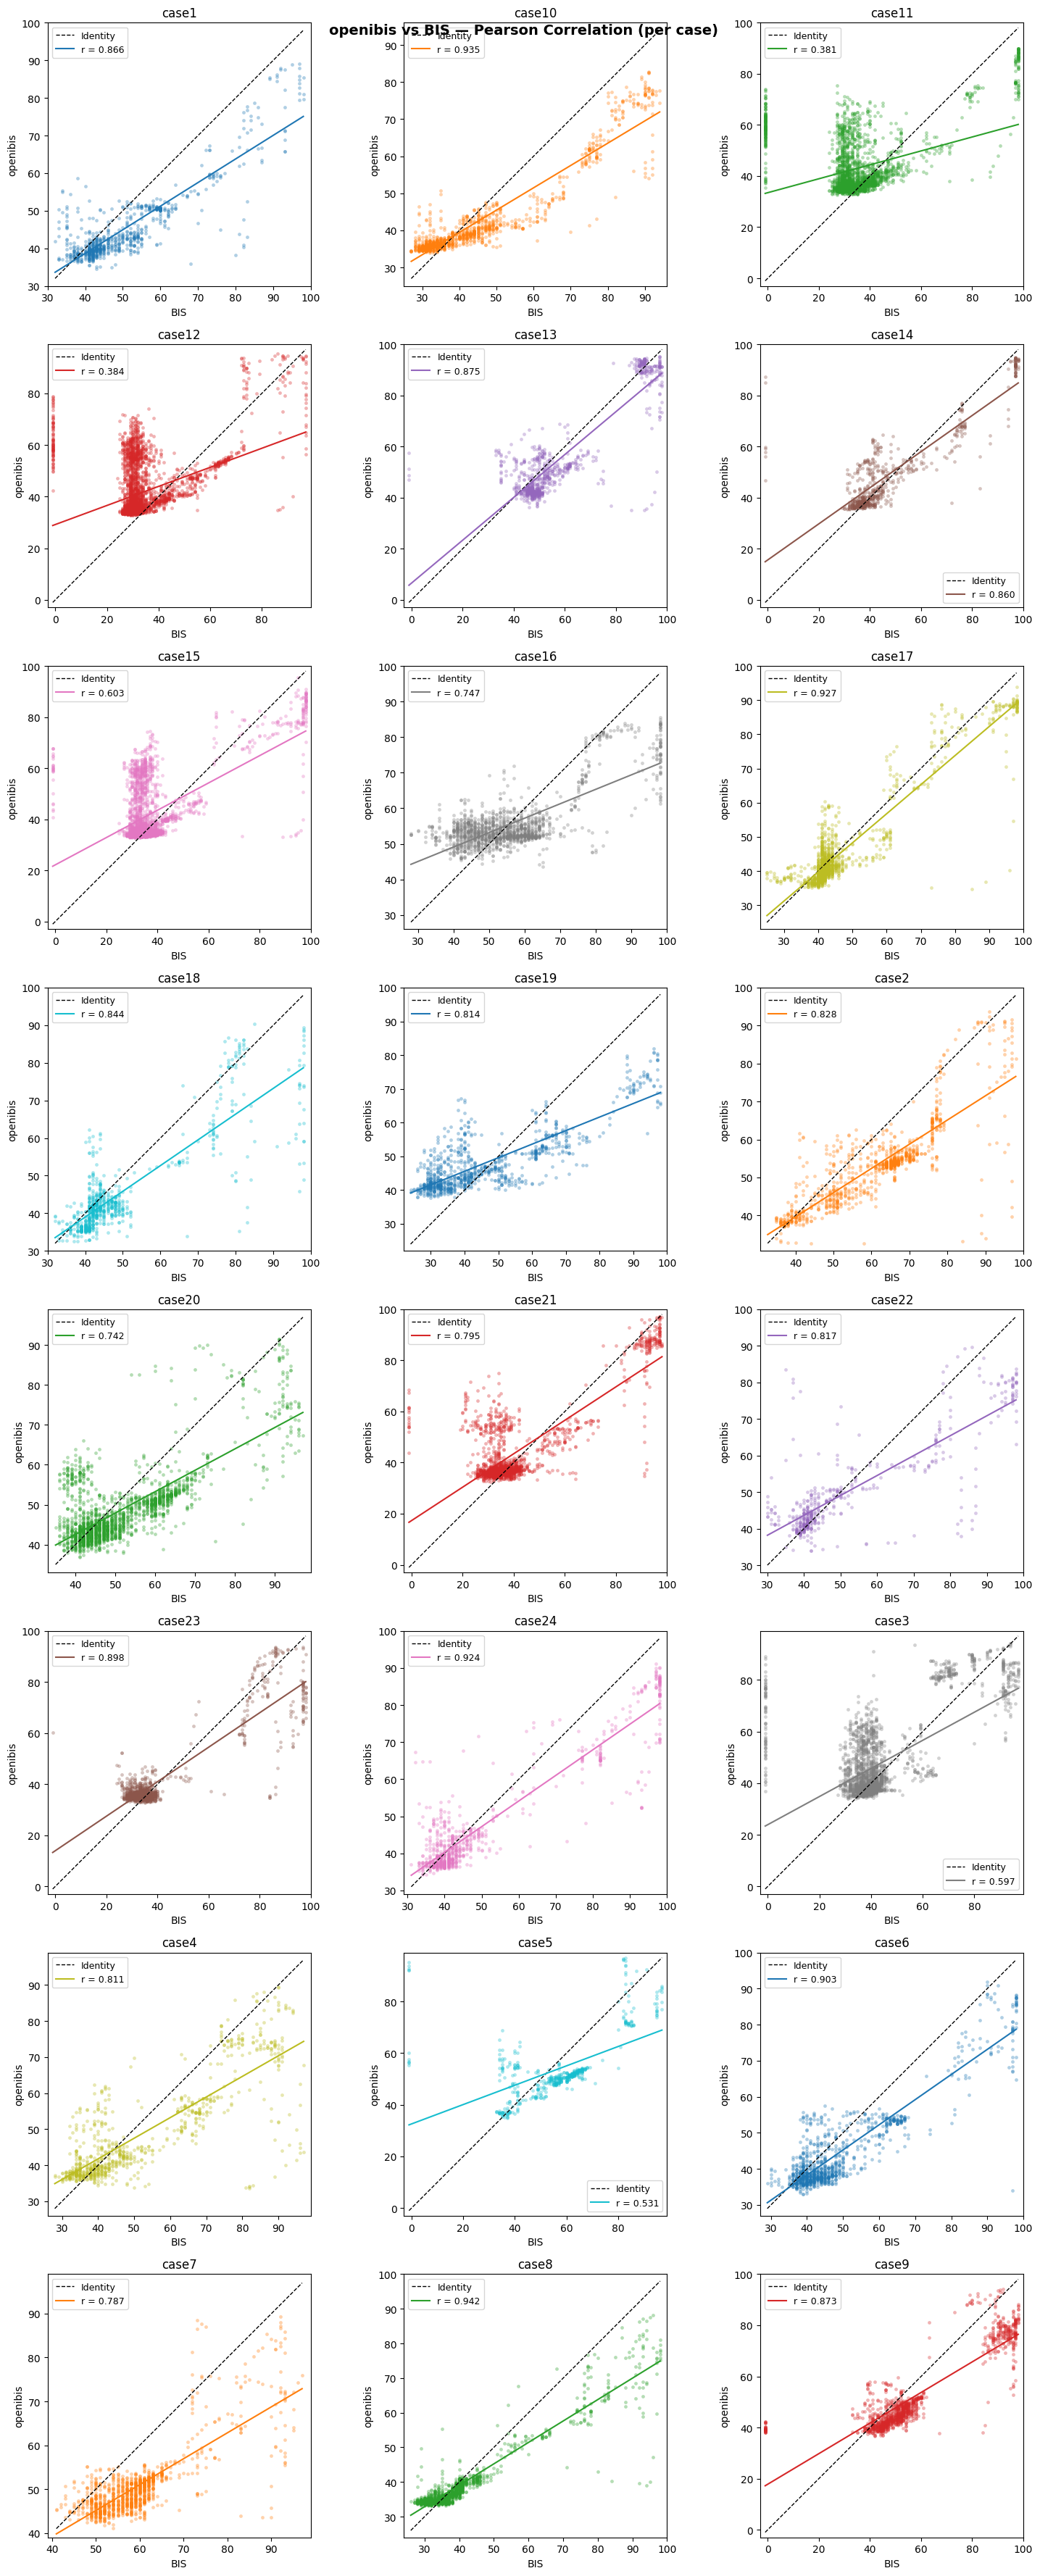

In [11]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
n_cases = len(results)
ncols   = min(3, n_cases)
nrows   = int(np.ceil(n_cases / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.5*nrows), squeeze=False)
fig.suptitle('openibis vs BIS — Pearson Correlation (per case)', fontsize=14, fontweight='bold')

for i, res in enumerate(results):
    ax    = axes[i // ncols][i % ncols]
    s, b  = res['scores'], res['bis']
    color = COLORS[i % len(COLORS)]
    lo, hi = min(b.min(), s.min()), max(b.max(), s.max())

    ax.scatter(b, s, alpha=0.35, s=12, color=color, linewidths=0)
    ax.plot([lo, hi], [lo, hi], 'k--', lw=1, label='Identity')
    m, b_int = np.polyfit(b, s, 1)
    xs = np.linspace(lo, hi, 200)
    ax.plot(xs, m*xs + b_int, color=color, lw=1.5, label=f"r = {res['r']:.3f}")
    ax.set(xlabel='BIS', ylabel='openibis', title=res['name'],
           xlim=(lo-2, hi+2), ylim=(lo-2, hi+2), aspect='equal')
    ax.legend(fontsize=9)

for j in range(n_cases, nrows * ncols):
    axes[j // ncols][j % ncols].set_visible(False)

fig.tight_layout()
plt.show()

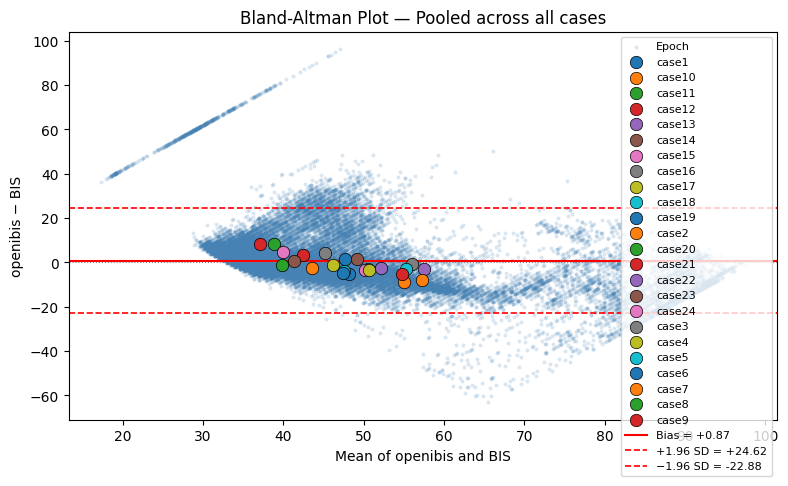

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

mean_all = (all_s + all_b) / 2
diff_all = all_s - all_b
ax.scatter(mean_all, diff_all, alpha=0.2, s=8, color='steelblue', linewidths=0, label='Epoch')

for i, res in enumerate(results):
    cm = (res['scores'] + res['bis']) / 2
    cd = res['scores'] - res['bis']
    ax.scatter(cm.mean(), cd.mean(), s=80, zorder=5,
               color=COLORS[i % len(COLORS)], edgecolors='k',
               linewidths=0.5, label=res['name'])

ax.axhline(bias_p,                color='red', lw=1.5, ls='-',  label=f'Bias = {bias_p:+.2f}')
ax.axhline(bias_p + 1.96 * sd_p,  color='red', lw=1.2, ls='--', label=f'+1.96 SD = {bias_p+1.96*sd_p:+.2f}')
ax.axhline(bias_p - 1.96 * sd_p,  color='red', lw=1.2, ls='--', label=f'−1.96 SD = {bias_p-1.96*sd_p:+.2f}')
ax.axhline(0, color='gray', lw=0.8, ls=':')

ax.set(xlabel='Mean of openibis and BIS', ylabel='openibis − BIS',
       title='Bland-Altman Plot — Pooled across all cases')
ax.legend(fontsize=8, loc='upper right')
fig.tight_layout()
plt.show()

# Conclusion
## Agreement Between openBIS and BIS

Agreement between openBIS and BIS was evaluated using Bland–Altman analysis, pooled across all cases. The mean bias (openBIS − BIS) was 0.87 units, indicating a minimal systematic difference between the two methods. Thus, on average, openBIS produced slightly higher values than BIS; however, the magnitude of this bias was small and unlikely to be meaningful at the group level.

The 95% limits of agreement ranged from −22.88 to 24.62 units, demonstrating substantial variability at the individual measurement level. Although the average bias was negligible, individual paired measurements could differ by approximately ±23–25 units.

Visual inspection of the Bland–Altman plot showed increasing dispersion of differences at higher mean values. In addition, more negative differences at higher mean indices were observed, indicating possible proportional bias across the measurement range.

When averaged at the case level, differences between methods were smaller and clustered closely around zero, suggesting improved agreement for aggregated measurements compared with epoch-by-epoch comparisons.

Overall, while openBIS and BIS demonstrated minimal systematic bias and comparable group-level means, the relatively wide limits of agreement indicate that the two methods are not interchangeable for individual measurements. However, for research applications involving group-level comparisons or trend analyses, the observed level of agreement may be acceptable. 

Although Openibis demonstrated minimal systematic bias relative to BIS at the group level, the limits of agreement are wide and there is evidence of proportional bias. Future work should formally model proportional bias and assess whether calibration approaches can reduce systematic deviation across the measurement range.

Prospective and external validation across independent datasets is needed to check generalizability.